In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

In [2]:

# -----------------------------
# Config
# -----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

VOCAB_SIZE = 100      # 0:[PAD], 1:[START], 2:[END], tokens 3..(VOCAB_SIZE-1)
D_MODEL = 128         # d_model in the paper (512 in base model) — smaller for speed
NUM_HEADS = 4         # h in the paper (8 in base model)
D_FF = 512            # inner FF dim (2048 in base model)
DROPOUT = 0.1
MAX_LEN = 30
EPOCHS = 5            # per user request
BATCH_SIZE = 128
WARMUP_STEPS = 4000   # as in paper


In [3]:
# -----------------------------
# Synthetic sequence-to-sequence dataset (Reversal task)
# -----------------------------
# Source: random token sequences (length 5..MAX_LEN-2). Target: the same tokens reversed, wrapped with [START] and [END].
# This stresses positional encodings and attention alignment without heavy data downloads.

def make_example(vocab_size=VOCAB_SIZE, min_len=5, max_len=MAX_LEN-2):
    L = np.random.randint(min_len, max_len+1)
    seq = np.random.randint(3, vocab_size, size=L, dtype=np.int32)  # avoid 0/1/2
    src = seq
    tgt = np.concatenate([[1], seq[::-1], [2]], axis=0)  # [START] ... reversed ... [END]
    return src, tgt


In [4]:
def pad_to_len(arr, length, pad=0):
    out = np.full((length,), pad, dtype=np.int32)
    out[:min(len(arr), length)] = arr[:min(len(arr), length)]
    return out


In [5]:
def build_dataset(n_samples=20000):
    srcs, tgts_in, tgts_out = [], [], []
    for _ in range(n_samples):
        src, tgt_full = make_example()
        # Inputs to encoder / decoder, and the decoder target (shifted by one)
        enc = pad_to_len(src, MAX_LEN)
        dec_in = pad_to_len(tgt_full[:-1], MAX_LEN)
        dec_out = pad_to_len(tgt_full[1:], MAX_LEN)
        srcs.append(enc)
        tgts_in.append(dec_in)
        tgts_out.append(dec_out)
    X_enc = np.stack(srcs)
    X_dec_in = np.stack(tgts_in)
    Y_dec_out = np.stack(tgts_out)
    return (X_enc, X_dec_in), Y_dec_out

In [6]:
# Train/Val/Test split
(Xe, Xd), Y = build_dataset(n_samples=24000)
idx = np.arange(len(Xe))
np.random.shuffle(idx)
Xe, Xd, Y = Xe[idx], Xd[idx], Y[idx]
N = len(Xe)
train_end, val_end = int(0.8*N), int(0.9*N)
Xe_tr, Xd_tr, Y_tr = Xe[:train_end], Xd[:train_end], Y[:train_end]
Xe_val, Xd_val, Y_val = Xe[train_end:val_end], Xd[train_end:val_end], Y[train_end:val_end]
Xe_te, Xd_te, Y_te = Xe[val_end:], Xd[val_end:], Y[val_end:]

train_ds = tf.data.Dataset.from_tensor_slices(((Xe_tr, Xd_tr), Y_tr)).shuffle(2048, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(((Xe_val, Xd_val), Y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [7]:
# -----------------------------
# Positional Encoding (sinusoidal) — Section 3.5 in paper
# -----------------------------

def positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angles = pos * angle_rates
    pe = np.zeros((max_len, d_model))
    pe[:, 0::2] = np.sin(angles[:, 0::2])
    pe[:, 1::2] = np.cos(angles[:, 1::2])
    return tf.constant(pe[np.newaxis, ...], dtype=tf.float32)  # (1, max_len, d_model)

PE = positional_encoding(MAX_LEN, D_MODEL)


In [8]:
# -----------------------------
# Masks
# -----------------------------

def create_padding_mask(seq):
    # seq: (batch, seq_len) int ids
    mask = tf.cast(tf.not_equal(seq, 0), tf.float32)  # 1 for non-pad
    return mask  # (batch, seq_len)



In [9]:

def create_look_ahead_mask(seq_len):
    # Lower triangular inclusive diagonal: 1s where allowed, 0s above diagonal
    la = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=tf.float32), -1, 0)
    return la  # (seq_len, seq_len)


In [10]:
# -----------------------------
# Attention sublayers (Keras MultiHeadAttention with score capture)
# -----------------------------
class SelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads, dropout=DROPOUT, name=None):
        super().__init__(name=name)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads,
                                             dropout=dropout)
        self.last_scores = None

    def call(self, x, mask=None, training=False):
        # Keras expects mask shape broadcastable to (batch, query_len, key_len). Values 1.0 keep, 0.0 mask.
        attn_out, attn_scores = self.mha(x, x, attention_mask=mask, training=training, return_attention_scores=True)
        self.last_scores = attn_scores  # (batch, heads, q_len, k_len)
        return attn_out

In [11]:
class CrossAttention(layers.Layer):
    def __init__(self, d_model, num_heads, dropout=DROPOUT, name=None):
        super().__init__(name=name)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads,
                                             dropout=dropout)
        self.last_scores = None

    def call(self, q, kv, mask=None, training=False):
        attn_out, attn_scores = self.mha(q, kv, attention_mask=mask, training=training, return_attention_scores=True)
        self.last_scores = attn_scores
        return attn_out



In [12]:
# -----------------------------
# Encoder & Decoder layers
# -----------------------------
class EncoderLayer(layers.Layer):
    def __init__(self, d_model=D_MODEL, num_heads=NUM_HEADS, dff=D_FF, dropout=DROPOUT):
        super().__init__()
        self.self_att = SelfAttention(d_model, num_heads, dropout, name="enc_self_att")
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.ff = tf.keras.Sequential([
            layers.Dense(dff, activation="relu"),
            layers.Dense(d_model),
        ])
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, padding_mask, training=False):
        # Build attention mask (batch, q_len, k_len)
        attn_mask = padding_mask[:, tf.newaxis, :]  # broadcast over q_len
        attn_out = self.self_att(x, mask=attn_mask, training=training)
        x = self.norm1(x + self.dropout1(attn_out, training=training))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_out, training=training))
        return x


In [13]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model=D_MODEL, num_heads=NUM_HEADS, dff=D_FF, dropout=DROPOUT):
        super().__init__()
        self.self_att = SelfAttention(d_model, num_heads, dropout, name="dec_self_att")
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)

        self.cross_att = CrossAttention(d_model, num_heads, dropout, name="dec_cross_att")
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

        self.ff = tf.keras.Sequential([
            layers.Dense(dff, activation="relu"),
            layers.Dense(d_model),
        ])
        self.dropout3 = layers.Dropout(dropout)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, enc_out, look_ahead_mask, dec_padding_mask, enc_padding_mask, training=False):
        # Masked self-attention in decoder
        # look_ahead_mask: (seq_len, seq_len), dec_padding_mask: (batch, seq_len)
        # Combine masks -> (batch, seq_len, seq_len)
        lam = look_ahead_mask[tf.newaxis, :, :]  # (1, L, L)
        dpm = dec_padding_mask[:, tf.newaxis, :]  # (B, 1, L)
        self_mask = lam * dpm
        attn1 = self.self_att(x, mask=self_mask, training=training)
        x = self.norm1(x + self.dropout1(attn1, training=training))

        # Cross-attention: query=decoder, key/value=encoder; mask uses encoder padding
        cpm = enc_padding_mask[:, tf.newaxis, :]  # (B, 1, src_len)
        attn2 = self.cross_att(x, enc_out, mask=cpm, training=training)
        x = self.norm2(x + self.dropout2(attn2, training=training))

        ff_out = self.ff(x)
        x = self.norm3(x + self.dropout3(ff_out, training=training))
        return x



In [14]:
# -----------------------------
# Token + positional embeddings
# -----------------------------
class TokenPositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, d_model, max_len):
        super().__init__()
        self.tok = layers.Embedding(vocab_size, d_model)
        self.pos = PE[:, :max_len, :]  # constant tensor

    def call(self, x):
        # x: (batch, seq_len)
        seq_len = tf.shape(x)[1]
        return self.tok(x) + self.pos[:, :seq_len, :]


In [15]:
# -----------------------------
# Full Transformer (1 encoder layer + 1 decoder layer)
# -----------------------------
class MiniTransformer(Model):
    def __init__(self, vocab_size, d_model=D_MODEL, num_heads=NUM_HEADS, dff=D_FF, max_len=MAX_LEN, dropout=DROPOUT):
        super().__init__()
        self.enc_emb = TokenPositionalEmbedding(vocab_size, d_model, max_len)
        self.dec_emb = TokenPositionalEmbedding(vocab_size, d_model, max_len)
        self.enc_layer = EncoderLayer(d_model, num_heads, dff, dropout)
        self.dec_layer = DecoderLayer(d_model, num_heads, dff, dropout)
        self.dropout = layers.Dropout(dropout)
        self.lm_head = layers.Dense(vocab_size)  # logits

    def call(self, inputs, training=False):
        enc_inp, dec_inp = inputs  # (B,L), (B,L)
        enc_padding_mask = create_padding_mask(enc_inp)
        dec_padding_mask = create_padding_mask(dec_inp)
        look_ahead = create_look_ahead_mask(tf.shape(dec_inp)[1])

        # Encoder
        x_enc = self.enc_emb(enc_inp)
        x_enc = self.dropout(x_enc, training=training)
        enc_out = self.enc_layer(x_enc, enc_padding_mask, training=training)

        # Decoder
        x_dec = self.dec_emb(dec_inp)
        x_dec = self.dropout(x_dec, training=training)
        dec_out = self.dec_layer(x_dec, enc_out, look_ahead, dec_padding_mask, enc_padding_mask, training=training)

        logits = self.lm_head(dec_out)
        return logits

    # Convenience to expose attention scores for visualization
    @property
    def attention_scores(self):
        return {
            "enc_self": self.enc_layer.self_att.last_scores,     # (B, H, L, L)
            "dec_self": self.dec_layer.self_att.last_scores,     # (B, H, L, L)
            "cross":    self.dec_layer.cross_att.last_scores,    # (B, H, L_dec, L_enc)
        }



In [16]:
# -----------------------------
# Noam learning-rate schedule (Eq. 3 in paper)
# -----------------------------
class NoamSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model=D_MODEL, warmup_steps=WARMUP_STEPS):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        return (self.d_model ** -0.5) * tf.minimum(step ** -0.5, step * (self.warmup ** -1.5))


In [17]:
# -----------------------------
# Loss & metrics (mask padding)
# -----------------------------
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [18]:
def masked_loss(y_true, y_pred):
    # y_true: (B,L) int ids, y_pred: (B,L,V)
    loss = loss_obj(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = loss * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


In [19]:
def masked_accuracy(y_true, y_pred):
    y_hat = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    matches = tf.cast(tf.equal(y_true, y_hat), tf.float32) * mask
    return tf.reduce_sum(matches) / tf.reduce_sum(mask)



In [20]:
# -----------------------------
# Build, compile, train
# -----------------------------
transformer = MiniTransformer(VOCAB_SIZE)
lr_schedule = NoamSchedule(D_MODEL, WARMUP_STEPS)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
transformer.compile(optimizer=opt, loss=masked_loss, metrics=[masked_accuracy])

history = transformer.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)


Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 47s 80ms/step - loss: 5.0215 - masked_accuracy: 0.0147 - val_loss: 4.5701 - val_masked_accuracy: 0.0574
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5795 - masked_accuracy: 0.0584 - val_loss: 4.4533 - val_masked_accuracy: 0.0629
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4578 - masked_accuracy: 0.0643 - val_loss: 4.3437 - val_masked_accuracy: 0.0664
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4018 - masked_accuracy: 0.0661 - val_loss: 4.3342 - val_masked_accuracy: 0.0668
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3816 - masked_accuracy: 0.0664 - val_loss: 4.3219 - val_masked_accuracy: 0.0666


In [21]:
# -----------------------------
# Greedy decoding for inference
# -----------------------------
START, END, PAD = 1, 2, 0


In [22]:
def greedy_decode(model, src, max_len=MAX_LEN):
    # src: (L,) int ids
    enc_inp = src[None, :]
    dec_seq = np.full((1, max_len), PAD, dtype=np.int32)
    dec_seq[0, 0] = START
    for t in range(1, max_len):
        logits = model([enc_inp, dec_seq], training=False)  # (1,L,V)
        next_id = int(tf.argmax(logits[0, t-1], axis=-1))
        dec_seq[0, t] = next_id
        if next_id == END:
            break
    return dec_seq[0]

In [23]:
# -----------------------------
# Quick demo on a random test example
# -----------------------------
idx = np.random.randint(0, len(Xe_te))
src = Xe_te[idx]
true_out = Y_te[idx]
pred = greedy_decode(transformer, src)

In [24]:
# Convert to list without pads
src_tokens = [int(x) for x in src if x != PAD]
true_tokens = [int(x) for x in true_out if x != PAD]
pred_tokens = [int(x) for x in pred if x != PAD]
print("\nSample src (ids):", src_tokens)
print("True tgt (ids): ", true_tokens)
print("Pred tgt (ids): ", pred_tokens)


Sample src (ids): [53, 80, 50, 29, 79, 57, 86, 51, 26, 12, 9]
True tgt (ids):  [9, 12, 26, 51, 86, 57, 79, 29, 50, 80, 53, 2]
Pred tgt (ids):  [1, 10, 50, 50, 70, 70, 70, 70, 27, 70, 70, 2]


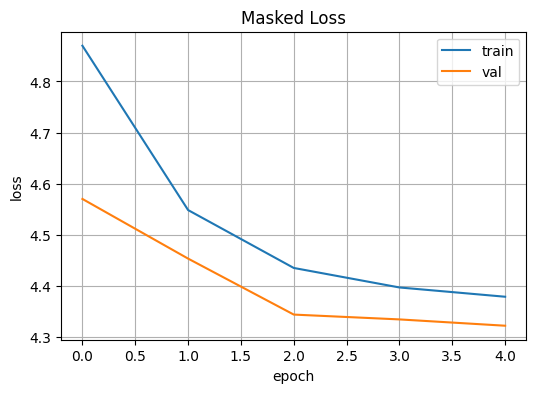

In [25]:
# -----------------------------
# Visualizations: training curves & attention heatmaps
# -----------------------------
# 1) Training curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Masked Loss'); plt.legend(); plt.grid(True)
plt.show()

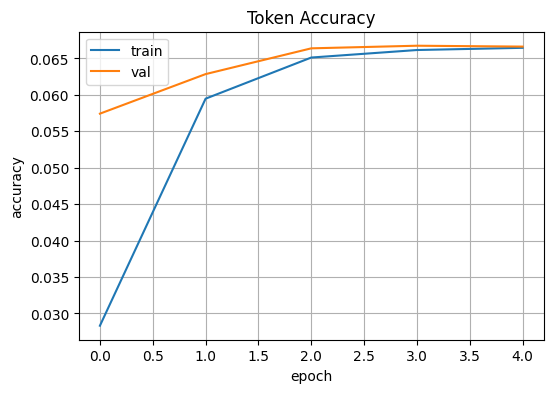

In [26]:
plt.figure(figsize=(6,4))
plt.plot(history.history['masked_accuracy'], label='train')
plt.plot(history.history['val_masked_accuracy'], label='val')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title('Token Accuracy'); plt.legend(); plt.grid(True)
plt.show()

In [27]:
# 2) Attention heatmaps (encoder self, decoder self, and cross-attention) on the same example
# Forward once to populate attention scores
_ = transformer([src[None, :], pred[None, :]], training=False)
att = transformer.attention_scores  # dict


In [28]:
# Helper to plot head grids

def plot_attn_map(scores, q_tokens, k_tokens, title):
    # scores: (1, H, Q, K) -> take [0]
    s = scores[0].numpy()
    H = s.shape[0]
    cols = min(4, H)
    rows = int(np.ceil(H/cols))
    plt.figure(figsize=(3.2*cols, 2.6*rows))
    for h in range(H):
        ax = plt.subplot(rows, cols, h+1)
        ax.imshow(s[h, :len(q_tokens), :len(k_tokens)], aspect='auto', cmap='viridis')
        ax.set_title(f'Head {h}')
        ax.set_xlabel('Key positions'); ax.set_ylabel('Query positions')
    plt.suptitle(title)
    plt.tight_layout(); plt.show()


In [29]:
enc_len = len(src_tokens)
dec_len = len([t for t in pred_tokens if t != END])

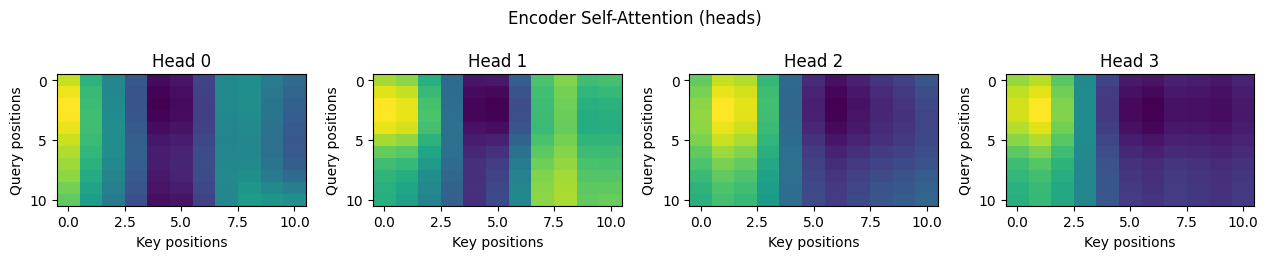

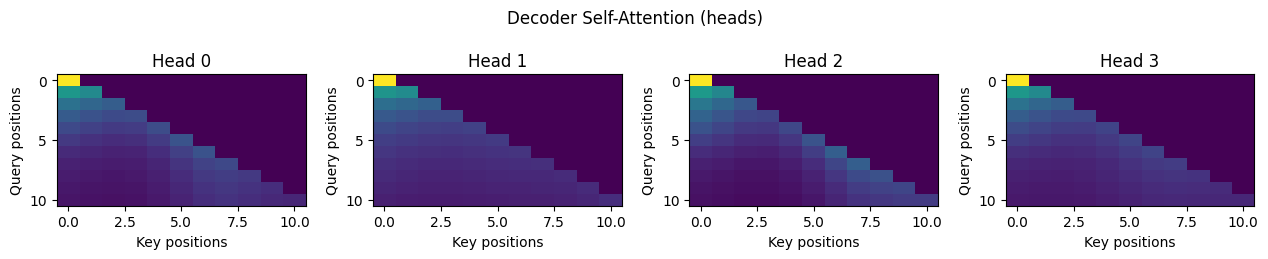

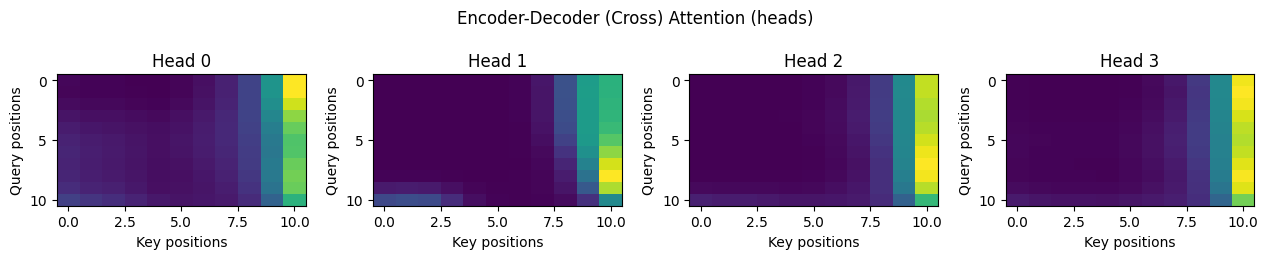


Done. This concise replication demonstrates the Transformer building blocks and training dynamics in a small, fast-to-run setting.


In [30]:

plot_attn_map(att['enc_self'], list(range(enc_len)), list(range(enc_len)), 'Encoder Self-Attention (heads)')
plot_attn_map(att['dec_self'], list(range(dec_len)), list(range(dec_len)), 'Decoder Self-Attention (heads)')
plot_attn_map(att['cross'], list(range(dec_len)), list(range(enc_len)), 'Encoder-Decoder (Cross) Attention (heads)')

print("\nDone. This concise replication demonstrates the Transformer building blocks and training dynamics in a small, fast-to-run setting.")
